In [1]:
import math
import numpy as np
import site, pprint
import pandas as pd
import seaborn as sns
from sklearn import datasets
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import FastICA
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
def normalise_(array):
  array = np.array(array)
  for dimension in range(len(array[0])):
    max_value = np.amax(array[:, dimension])
    min_value = np.amin(array[:, dimension])
    abs_max = max(abs(max_value), abs(min_value))
    array[:, dimension] = np.divide(array[:, dimension], abs_max)
  return array


def Kernel(array, d):
  normilised_distances = []
  for sample in range(len(array)):
    local_dist = []
    for dist in range(len(array[0])):
      power = -dist * math.log(d)/2
      normilised = math.pow(math.e,power) * math.log(d)
      local_dist.append(normilised)
    normilised_distances.append(local_dist)
  return normilised_distances



def best_Alpha(X, y):
  best_model = None
  best_score = 10000
  alphas = [0.1, 1.0, 10]
  best_a = 0
  performances = []
  for a in alphas:
    temp_model = Ridge(alpha = a).fit(X, y)
    temp_perfomance = abs(mean_squared_error(y, temp_model.predict(X)))
    performances.append(temp_perfomance)
    if temp_perfomance < best_score:
      best_score = temp_perfomance
      best_model = temp_model
      best_a = a
  return best_model #, best_a, performances



def get_nearest_neighbs(initial_data, number_of_neghbours):
  neighbs_for_each_sample = []
  for i in range(len(initial_data)):
    neigh = NearestNeighbors(n_neighbors = number_of_neghbours)
    neigh.fit(initial_data)
    All_50_neighbors = neigh.kneighbors(initial_data[i].reshape(1, -1), return_distance=False)[0]
    neighbs_for_each_sample.append(All_50_neighbors)

  total_neighbs = []
  for i in range(len(neighbs_for_each_sample)):
    local_neighb = [] 
    for sample in neighbs_for_each_sample[i]:
      local_neighb.append(initial_data[sample])
    total_neighbs.append(local_neighb)
  return total_neighbs



def get_Lime_Neighbs(initial_data, DM_func, number_of_neghbours):
  from lime.lime_tabular import LimeTabularExplainer
  explainer =  LimeTabularExplainer(training_data = initial_data, discretize_continuous = False, mode = "regression", random_state=0)

  all_LIME_neighbs = []
  all_reduced_LIME_neighbs = []
  all_LIME_distances = []
  for sample in range(len(initial_data)):
    temp = explainer.give_me_the_neighbourhood(initial_data[sample], DM_func, num_samples=number_of_neghbours)
    all_LIME_neighbs.append(temp[0])
    all_reduced_LIME_neighbs.append(temp[1])
    all_LIME_distances.append(temp[2])
  return all_LIME_neighbs, all_reduced_LIME_neighbs, all_LIME_distances



def get_Transformed_total_neighbs(total_neighbs, DM_func):
  Transformed_total_neighbs = []
  for i in range(len(total_neighbs)):
    Transformed_total_neighbs.append(DM_func(total_neighbs[i]))
  return Transformed_total_neighbs



def get_euclidean_distances(initial_data, total_neighbs):
  total_distances = []
  for sample in range(len(initial_data)):
    total_distances.append(euclidean_distances(initial_data[sample].reshape(1, -1), total_neighbs[sample].reshape(-1, len(initial_data[0])))[0])
  return total_distances



def get_total_coef(total_neighbs_np, Transformed_total_neighbs_np, linear_model):
  total_coef = []

  for sample in range(len(total_neighbs_np)):
    local_coef = []
    for column in range(len(Transformed_total_neighbs_np[0][0])):
      clf = linear_model.fit(total_neighbs_np[sample], Transformed_total_neighbs_np[sample,:,column])#, normilised_distances[sample])
      local_coef.append(clf.coef_)
    total_coef.append(local_coef)
  return (total_coef)


def create_reduced_space_data(initial_data, coef_1):
  X_new = initial_data - initial_data.mean(axis=0)
  model_summed_values = []

  for sample in range(len(initial_data)):
    model_summed_value = []
    for dimension in range(len(coef_1[0])):
      model_value = X_new[sample] * coef_1[sample][dimension]
      model_summed_value.append(sum(model_value))
    model_summed_values.append(model_summed_value)
  return model_summed_values


def explain(initial_data, initial_predictions, DM_func, number_of_neghbours, find_Alpha, use_LIME_neighbs):
  if use_LIME_neighbs:
    total_neighbs, Transformed_total_neighbs, total_distances = get_Lime_Neighbs(initial_data, DM_func, number_of_neghbours)
  else:
    total_neighbs = get_nearest_neighbs(initial_data, number_of_neghbours)
    Transformed_total_neighbs = get_Transformed_total_neighbs(total_neighbs, DM_func)
    #total_distances = get_euclidean_distances(initial_data, total_neighbs)
    
  initial_data_np = np.array(initial_data)
  total_neighbs_np = np.array(total_neighbs)
  Transformed_total_neighbs_np = np.array(Transformed_total_neighbs)

  total_distances = get_euclidean_distances(initial_data_np, total_neighbs_np)

  if find_Alpha:
    linear_model = best_Alpha(initial_data, initial_predictions)
  else:
    linear_model = Ridge(alpha=10)

  total_coef = get_total_coef(total_neighbs_np, Transformed_total_neighbs_np, linear_model)
  reduced_space_data = create_reduced_space_data(initial_data, total_coef)
  return total_coef, reduced_space_data, total_neighbs_np, total_distances



def find_error(initial_data, model_Transformed_dataset, Transformed_dataset):
  mae = mean_absolute_error(Transformed_dataset, model_Transformed_dataset)
  print("mean_absolute_error = ",mae)

  Transformed_dataset_np = np.array(Transformed_dataset)
  model_summed_values_np = np.array(model_Transformed_dataset)

  cos_sum = 0
  euc_sum = 0
  for sample in range(len(Transformed_dataset)):
    cos_sum += 1 - cosine_similarity(np.array([Transformed_dataset_np[sample]]), np.array([model_summed_values_np[sample]]))
    euc_sum += euclidean_distances(np.array([Transformed_dataset_np[sample]]), np.array([model_summed_values_np[sample]]))

  cos_error = cos_sum/len(Transformed_dataset)
  euc_error = euc_sum/len(Transformed_dataset)

  print("cosine error = ", cos_error[0][0])
  print("euclidean error = ", euc_error[0][0])

  return mae, cos_error, euc_error



#only works if the DM technique can return PCA like components
def visualise(sample, initial_data, coef_1, coef_2):
  X_new = initial_data - initial_data.mean(axis=0)
  model_value = X_new[sample] * coef_1[sample][1]
  pca_value = X_new[sample]  * coef_2.T[:,1]

  index_ = []
  for i in range(len(model_value)):
    index_.append("f" + str(i))

  size = math.sqrt(len(model_value)) * 3
  plotdata = pd.DataFrame({
      "Model":model_value,
      "PCA":pca_value,
      }, 
      index=index_
  )
  plt.rcParams["figure.figsize"] = [size, 6]
  plotdata.plot(kind="bar", rot=0)
  plt.title("value comparison")
  plt.xlabel("features")
  plt.ylabel("values")
  plt.show() 


def create_heatmap(sample, coef_1, coef_2):
  features = []
  for i in range(len(coef_1[sample][0])):
    features.append("F" + str(i))

  components = []
  for i in range(len(coef_1[sample])):
    components.append("C" + str(i))

  coef_1_np = np.array(coef_1[sample])
  coef_2_np = np.array(coef_2)
  scores = abs(np.subtract(coef_1_np, coef_2_np)) 

  ax = sns.heatmap( scores , annot=True, fmt='.2f', linewidth = 0.1 , cmap = 'hot_r', xticklabels = features, yticklabels = components ) 

  plt.xlabel('Features')
  plt.ylabel('Components')
  plt.title( "error between weights" ) 
  plt.show() 

In [3]:
!python --version

Python 3.7.10


In [4]:
import site, pprint
pprint.pprint(site.getsitepackages())

['/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.7/dist-packages']


In [5]:
!python -m site --user-site

/root/.local/lib/python3.7/site-packages


In [6]:
!pip install lime==0.2.0.1

In [7]:
!mv lime_tabular.py /usr/local/lib/python3.7/dist-packages/lime/

In [8]:
ls /usr/local/lib/python3.7/dist-packages/lime/

bundle.js       __init__.py      lime_text.py        utils/
discretize.py   lime_base.py     __pycache__/        webpack.config.js
exceptions.py   lime_image.py    submodular_pick.py  wrappers/
explanation.py  lime_tabular.py  tests/


In [9]:
#datasets
iris = datasets.load_iris()
initial_data = iris.data
initial_predictions = iris.target

#diabetes = datasets.load_diabetes()
#initial_data = diabetes.data
#initial_predictions = diabetes.target

#digits = datasets.load_digits()
#initial_data = digits.data
#initial_predictions = digits.target

#number of dimensions we want the dataset to be reduced to
components = 3
number_of_neighbours = 50

#this sample will be used for visualisation
sample = 0

mean_absolute_error =  0.03327349273172964
cosine error =  0.00010115587765011498
euclidean error =  0.06848791453161511


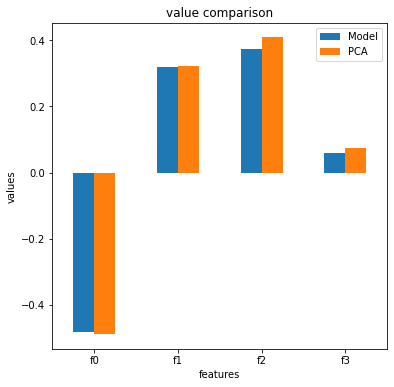


the visualisation above corresponds to the C1 component of the heatmap, values dont line up exactly because we visualise the reduced space values and not the weights (components) as we do with the heatmap


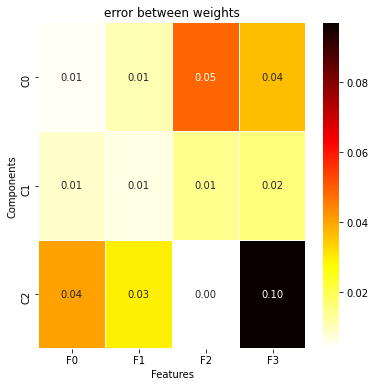


First reduced sample of PCA = [-2.68412563  0.31939725 -0.02791483]

First reduced sample of PCA after normalisation = [-0.70715921  0.23243004 -0.03672204]


In [10]:
pca = PCA(n_components=components)
pca.fit(initial_data)
PCA_Transformed_dataset = pca.fit_transform(initial_data)

total_coef, model_transformed_dataset, total_neighbs_np, total_distances = explain(initial_data, initial_predictions, pca.transform, number_of_neighbours, find_Alpha = True, use_LIME_neighbs = False)
mae, cosine_s, euc_error = find_error(initial_data, model_transformed_dataset, PCA_Transformed_dataset)
visualise(sample, initial_data, total_coef, pca.components_)

#new implementations
print("")
print("the visualisation above corresponds to the C1 component of the heatmap, values dont line up exactly because we visualise the reduced space values and not the weights (components) as we do with the heatmap")
create_heatmap(sample, total_coef,  pca.components_)
print("")
print("First reduced sample of PCA =", PCA_Transformed_dataset[0])
normalised_PCA_Transformed_dataset = normalise_(PCA_Transformed_dataset)
print("")
print("First reduced sample of PCA after normalisation =", normalised_PCA_Transformed_dataset[0])

mean_absolute_error =  0.27678367878615834
cosine error =  0.026143973441624755
euclidean error =  0.5638581537399204


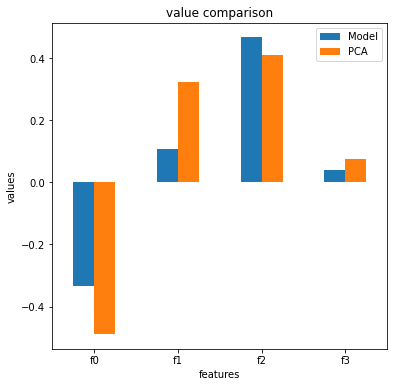

In [11]:
total_coef, model_transformed_dataset, total_neighbs_np, total_distances = explain(initial_data, initial_predictions, pca.transform, number_of_neighbours, find_Alpha = False, use_LIME_neighbs = True)
mae, cosine_s, euc_error = find_error(initial_data, model_transformed_dataset, PCA_Transformed_dataset)
visualise(sample, initial_data, total_coef, pca.components_)

mean_absolute_error =  0.03327349273172964
cosine error =  0.00010115587765011498
euclidean error =  0.06848791453161511


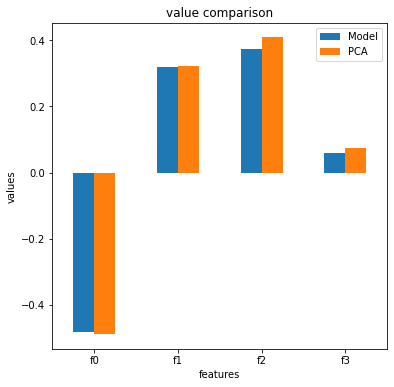

In [12]:
total_coef, model_transformed_dataset, total_neighbs_np, total_distances = explain(initial_data, initial_predictions, pca.transform, number_of_neighbours, find_Alpha = True, use_LIME_neighbs = False)
mae, cosine_s, euc_error = find_error(initial_data, model_transformed_dataset, PCA_Transformed_dataset)
visualise(sample, initial_data, total_coef, pca.components_)

mean_absolute_error =  0.43464710233443143
cosine error =  0.026244464999049474
euclidean error =  0.978678998477691


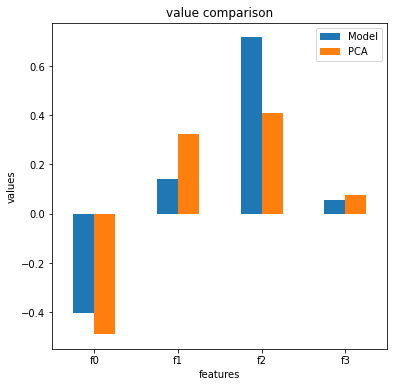

In [13]:
total_coef, model_transformed_dataset, total_neighbs_np, total_distances = explain(initial_data, initial_predictions, pca.transform, number_of_neighbours, find_Alpha = True, use_LIME_neighbs = True)
mae, cosine_s, euc_error = find_error(initial_data, model_transformed_dataset, PCA_Transformed_dataset)
visualise(sample, initial_data, total_coef, pca.components_)

In [14]:
#X_embedded = TSNE(n_components=components)
#X_embedded.fit(initial_data)
#Transformed_dataset = X_embedded.fit_transform(initial_data)

#total_coef, total_neighbs_np, total_distances = explain(initial_data, initial_predictions, X_embedded.fit_transform, find_Alpha = True, use_LIME_neighbs = False)
#mae, cs = find_mean_absolute_error(initial_data, total_coef, Transformed_dataset)

In [15]:
transformer = KernelPCA(n_components=components, kernel='linear')
kernel_transformed = transformer.fit(initial_data)
kernel_Transformed_dataset = transformer.fit_transform(initial_data)

total_coef, model_transformed_dataset, total_neighbs_np, total_distances = explain(initial_data, initial_predictions, kernel_transformed.transform, number_of_neighbours, find_Alpha = True, use_LIME_neighbs = False)
mae, cosine_s, euc_error = find_error(initial_data, model_transformed_dataset, kernel_Transformed_dataset)

mean_absolute_error =  0.03327349273172934
cosine error =  0.00010115587765009723
euclidean error =  0.06848791453161139


mean_absolute_error =  0.0035178435399862134
cosine error =  0.001894164094940863
euclidean error =  0.007215616359426358


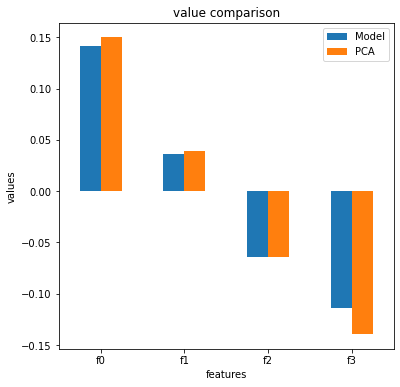

In [16]:
transformer = FastICA(n_components=components, random_state=0)
transformer.fit(initial_data)
Transformed_dataset = transformer.fit_transform(initial_data)

total_coef, model_transformed_dataset, total_neighbs_np, total_distances = explain(initial_data, initial_predictions, transformer.transform, number_of_neighbours, find_Alpha = True, use_LIME_neighbs = False)
mae, cosine_s, euc_error = find_error(initial_data, model_transformed_dataset, Transformed_dataset)
visualise(sample, initial_data, total_coef, transformer.components_)

In [17]:
#initial data should not contain negative values
#this dataset had negative values so i didnt run this cell

model = NMF(n_components=components, random_state=0)
model.fit(initial_data)
Transformed_dataset = model.fit_transform(initial_data)

total_coef, model_transformed_dataset, total_neighbs_np, total_distances = explain(initial_data, initial_predictions, model.transform, number_of_neighbours, find_Alpha = True, use_LIME_neighbs = False)
mae, cosine_s, euc_error = find_error(initial_data, model_transformed_dataset, Transformed_dataset)


mean_absolute_error =  0.4263642278196312
cosine error =  0.6348679578745037
euclidean error =  0.8367543024365107


In [18]:
# i got the same issue as the NMF, the current initial data contained 
lda = LatentDirichletAllocation(n_components=components, random_state=0)
lda.fit(initial_data)
Transformed_dataset = lda.fit_transform(initial_data)


total_coef, model_transformed_dataset, total_neighbs_np, total_distances = explain(initial_data, initial_predictions, lda.transform, number_of_neighbours, find_Alpha = True, use_LIME_neighbs = False)
mae, cosine_s, euc_error = find_error(initial_data, model_transformed_dataset, Transformed_dataset)

mean_absolute_error =  0.3333333333333334
cosine error =  0.7989360242972499
euclidean error =  0.9398711919176734
